## Librerias


In [1]:
import itertools
import pandas as pd
import numpy as np
from random import gauss

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox

from scipy.stats import shapiro
from scipy.stats import probplot

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 

import warnings
warnings.simplefilter(action='ignore', category= FutureWarning)

## Ajuste de gráficas

In [2]:
class CFG:
    data_folder = r"C:\Users\santi\Desktop\Santiago"
    img_dim1 = 20
    img_dim2 = 10    
# ajustar el tamaño de las figuras
    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})    


In [3]:
%pip install arch

## Volatility clustering

Los altos periodos de volatilidad suelen juntarse con más periodos de volatilidad, lo que provoca que se formen grupos(clusters), lo mismo sucede para periodos de baja volatilidad

<Axes: xlabel='Date'>

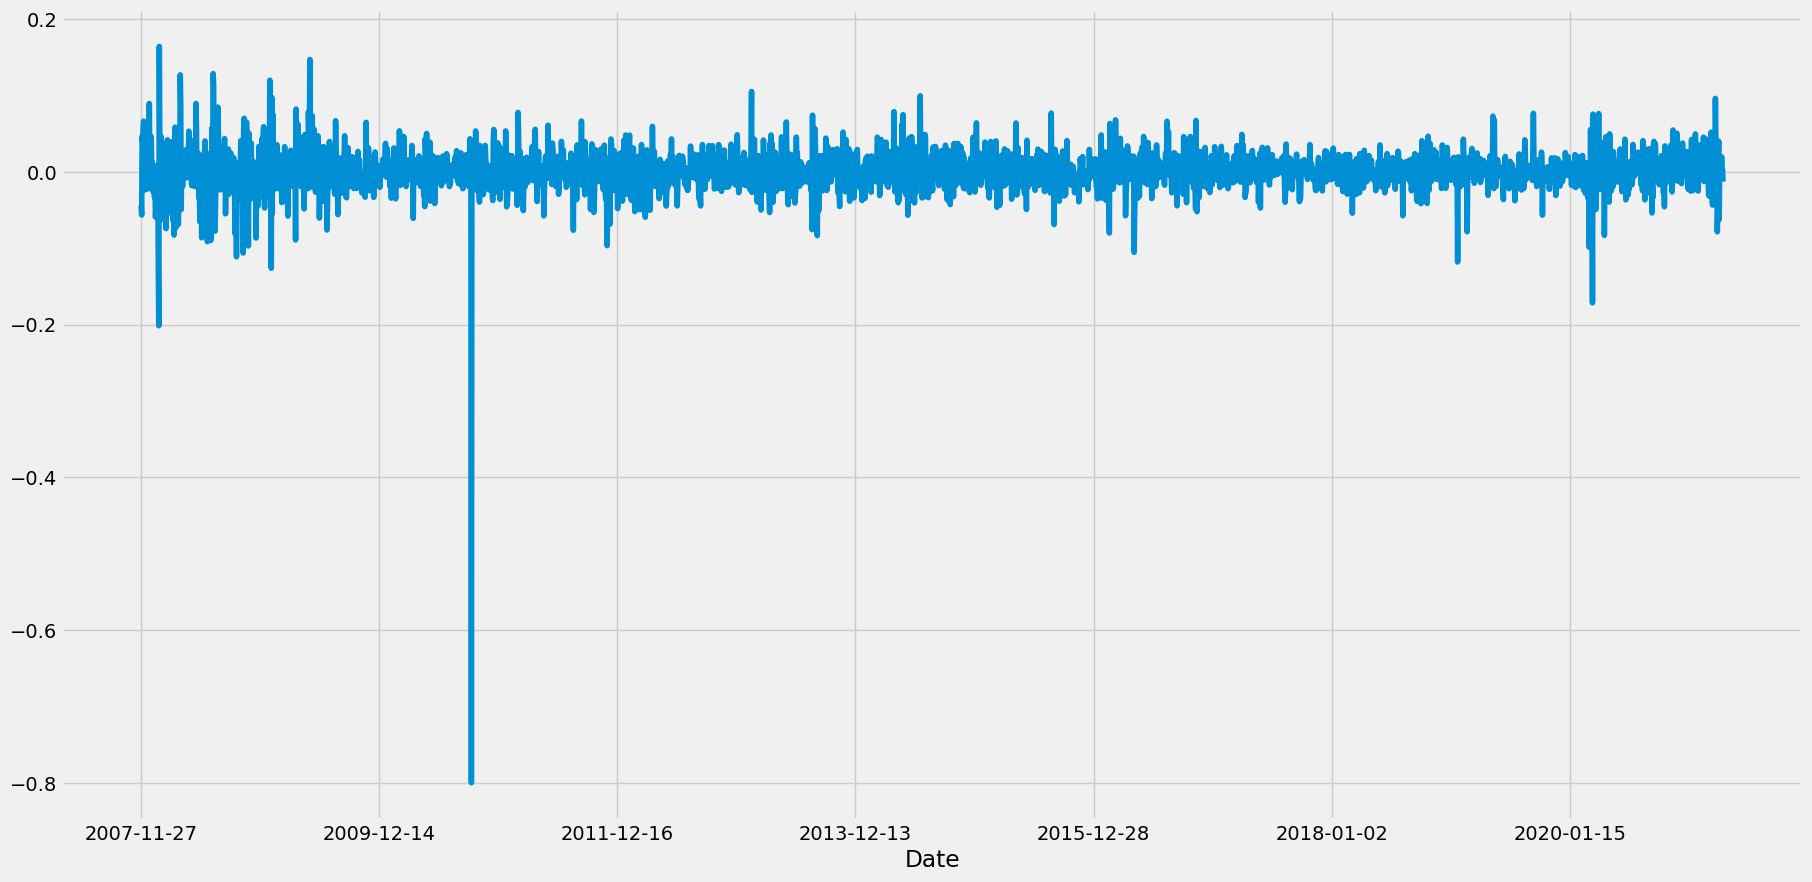

In [13]:

df = pd.read_csv(r"C:\Users\santi\Desktop\Santiago\ADANIPORTS.csv")
df.set_index("Date", drop=False, inplace=True)

df.VWAP.pct_change().plot()
#vwap es el precio promedio ponderado por volumen
#pct_change es el cambio porcentual
#vwap es la relación entre el valor de un activo financiero...
#...negociado y el volumen total de transacciones durante una sesión de negociación


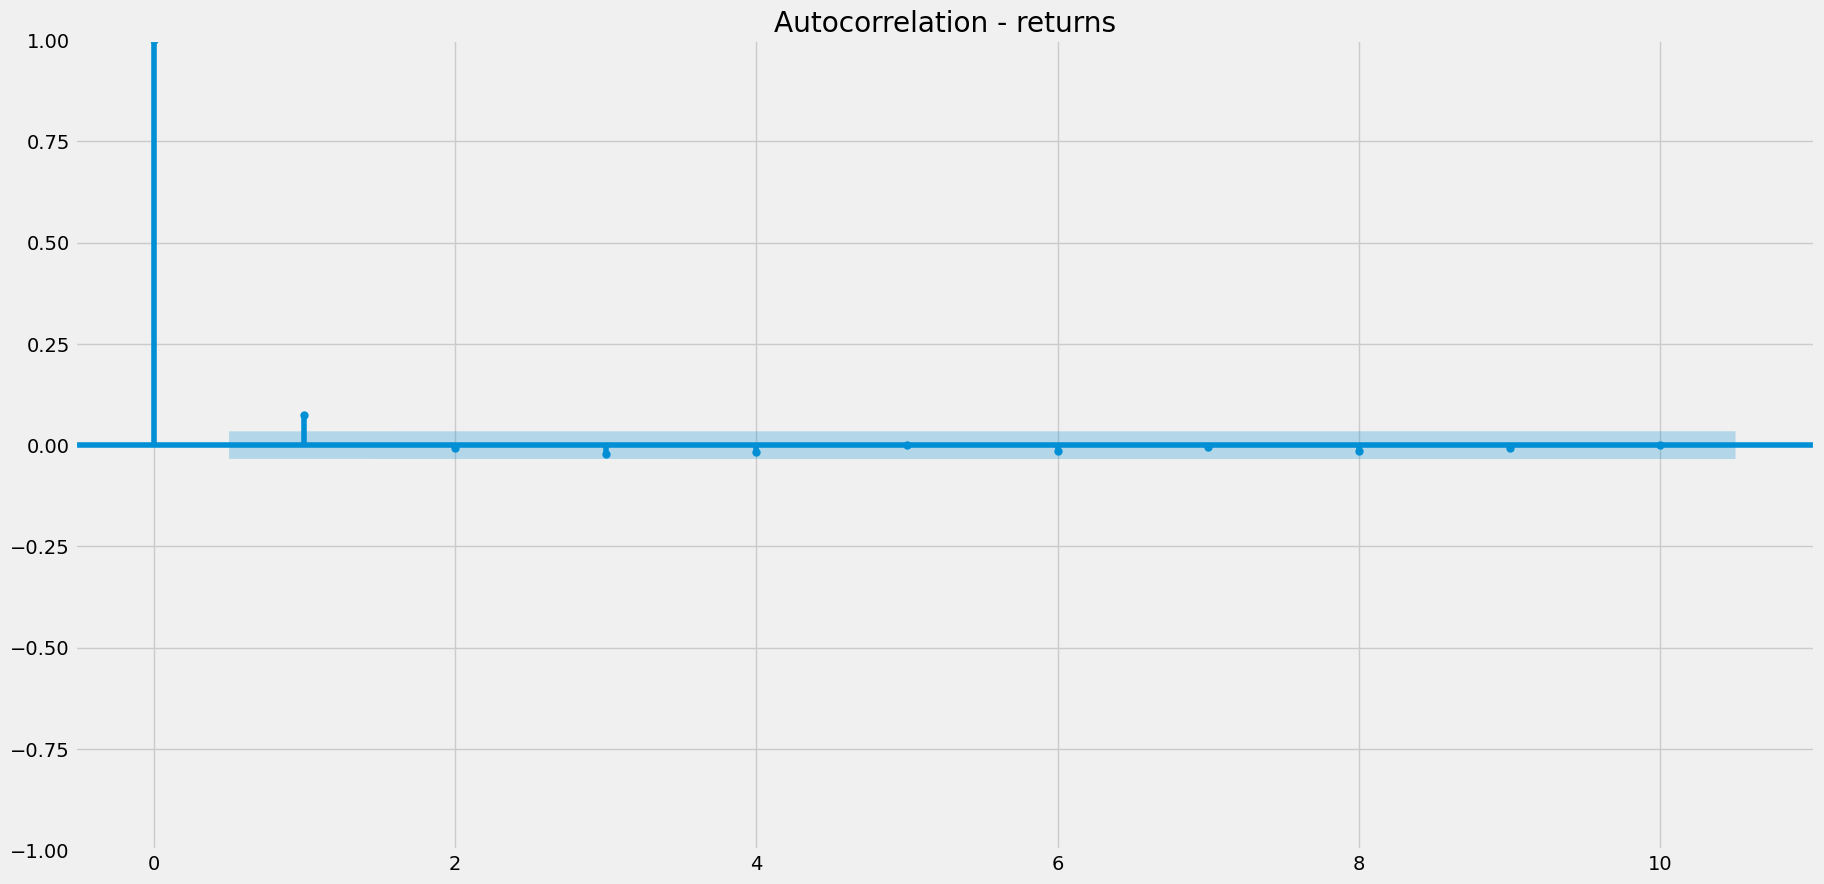

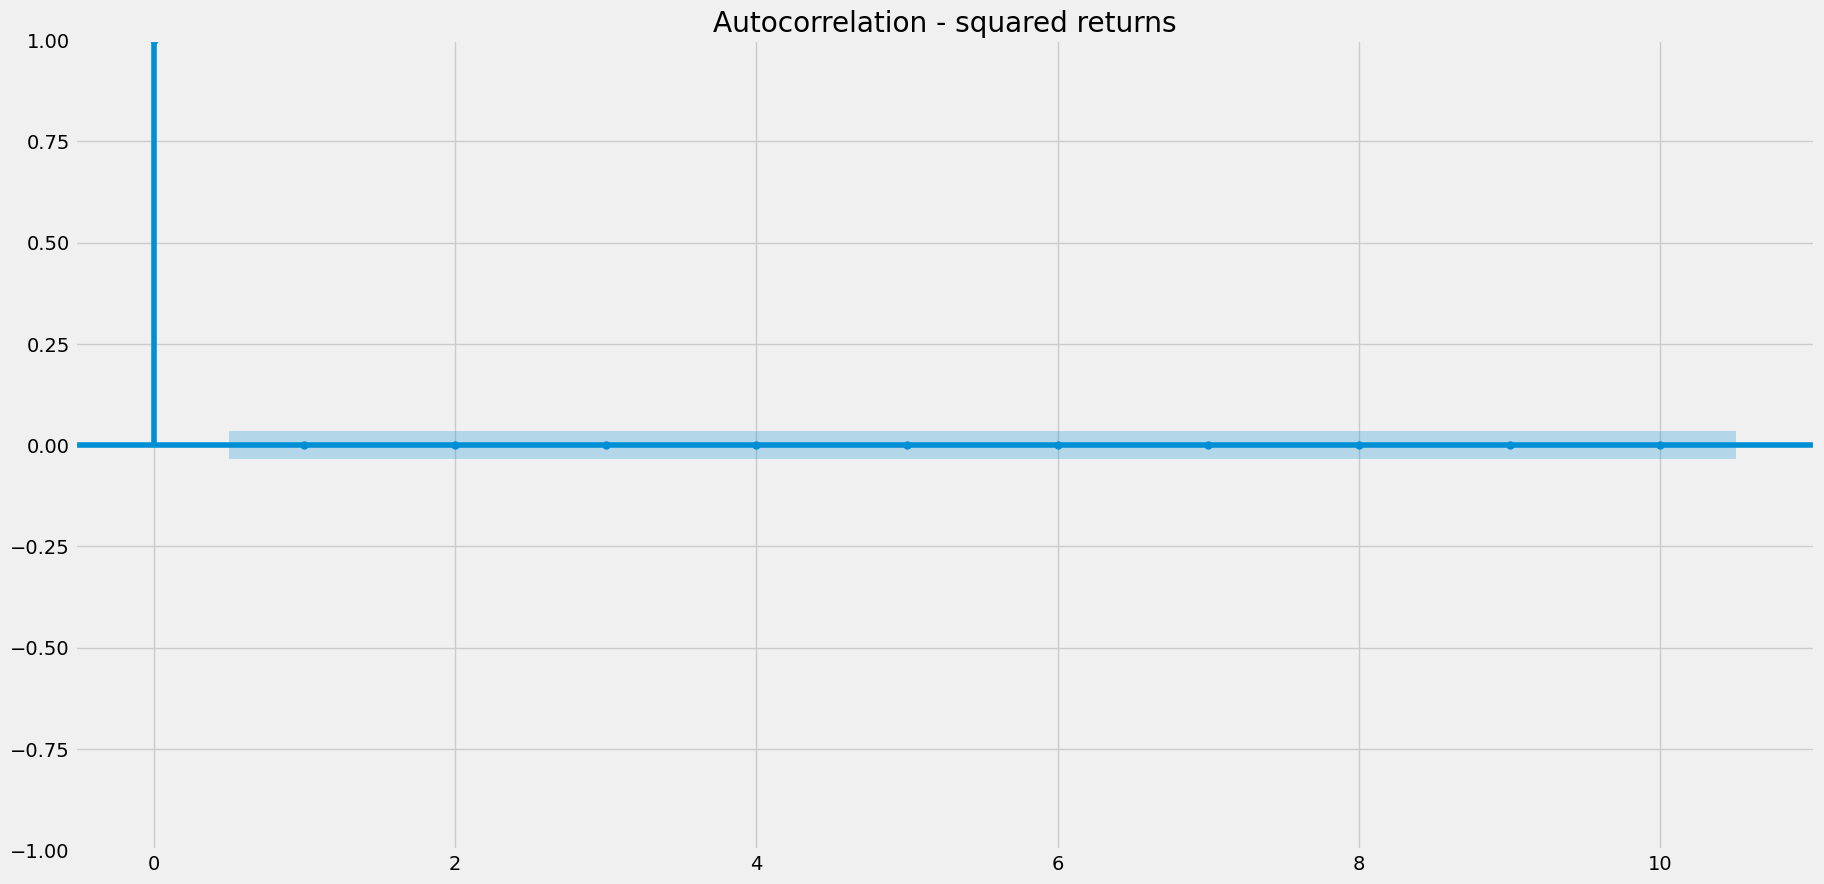

In [14]:
dfl = np.log1p(df.VWAP).diff().dropna()
# log1p es el logaritmo natural de 1 + x, se suma uno para evitar indeterminacione en valores de cero
#.diff calcula la diferencia entre los valores logaritmizados consecutivos. Esto da la variación entre...
#... los períodos.
plot_acf(dfl, lags = 10, title='Autocorrelation - returns'); print()
plot_acf(dfl**2, lags = 10, title='Autocorrelation - squared returns'); print()

La **ACF** muestra cómo las observaciones en un momento dado se correlacionan con las observaciones en momentos anteriores (lags).
Si hay un pico significativo en el desfase 1, indica una correlación fuerte entre las observaciones adyacentes.

Aplicar la **ACF** a los retornos al cuadrado, obtenemos información sobre la varianza condicional de los retornos.

La **varianza condicional** mide la cantidad de variación que queda en la variable (X) después de que parte de ella se “explica” mediante su asociación con otras variables aleatorias, como (Y), (X), (W), etc.

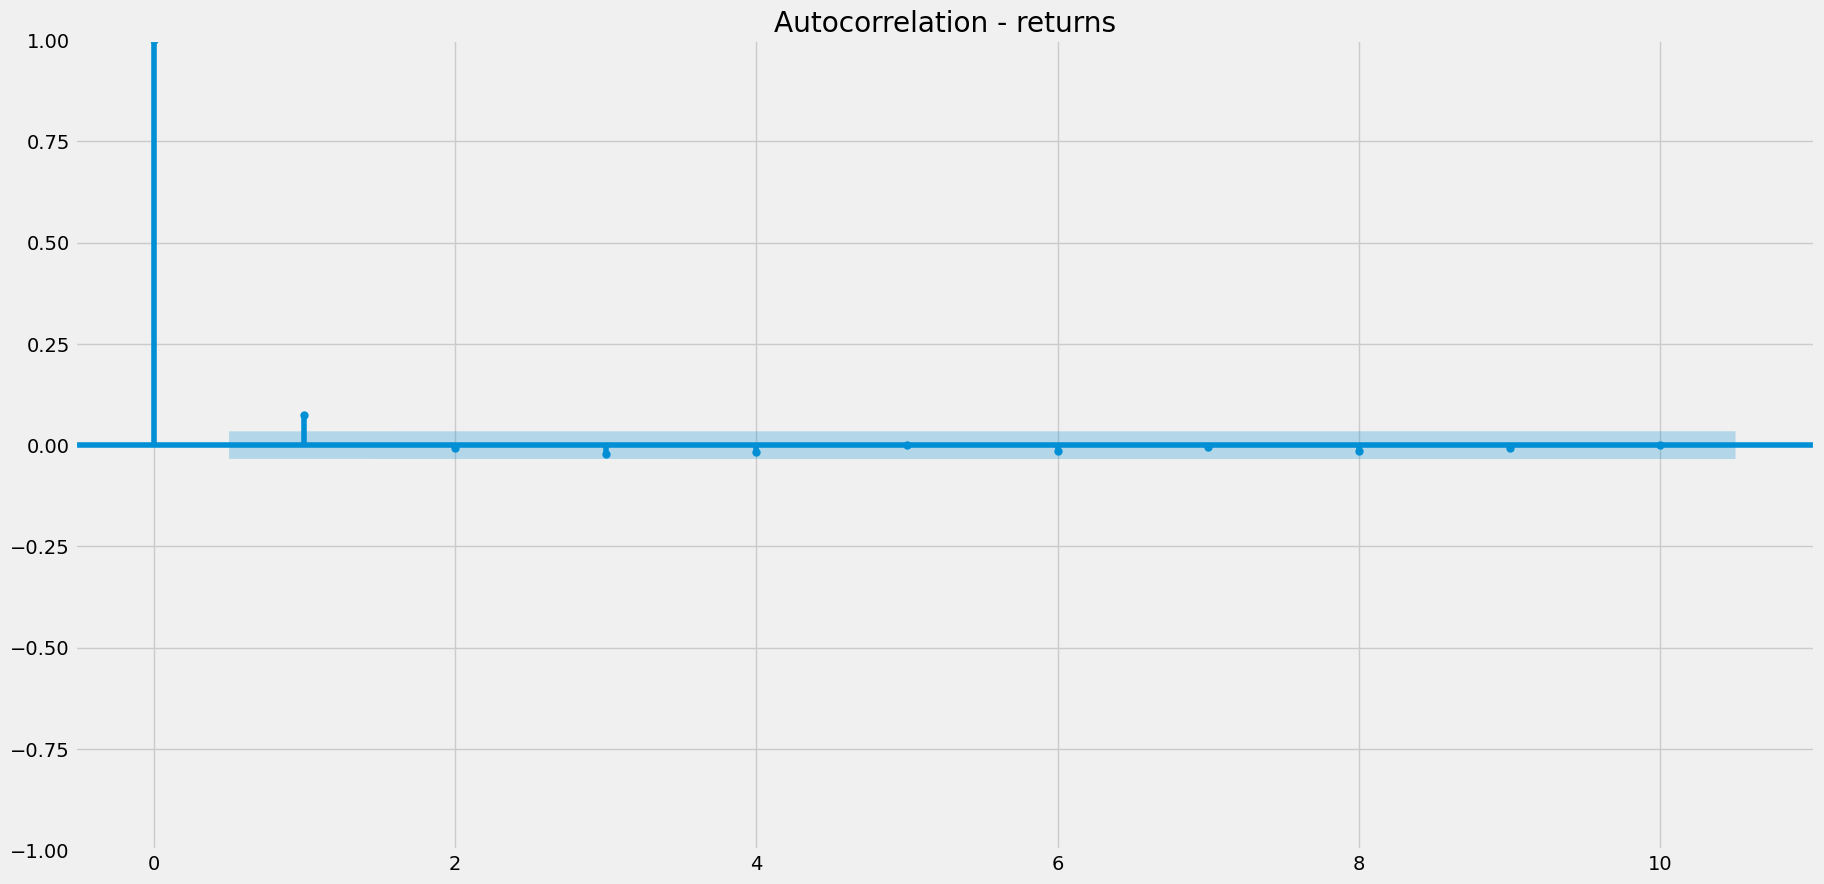

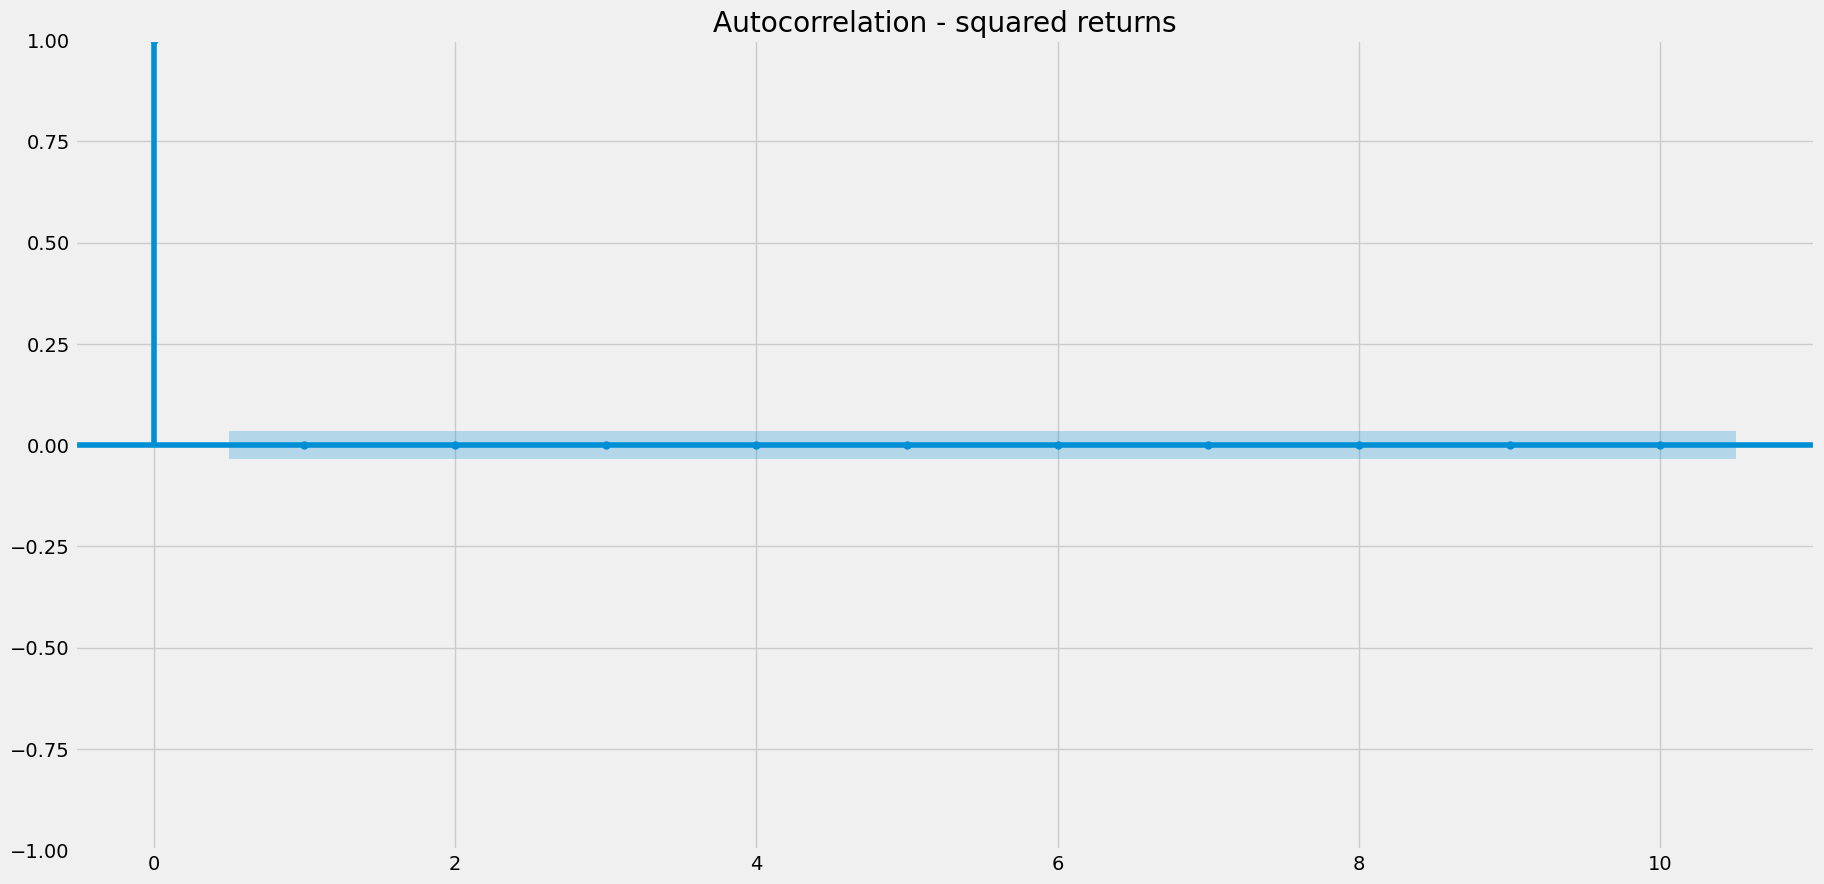

In [15]:
dfl = np.log1p(df.VWAP).diff().dropna()
plot_acf(dfl, lags = 10, title='Autocorrelation - returns'); print()
plot_acf(dfl**2, lags = 10, title='Autocorrelation - squared returns'); print()

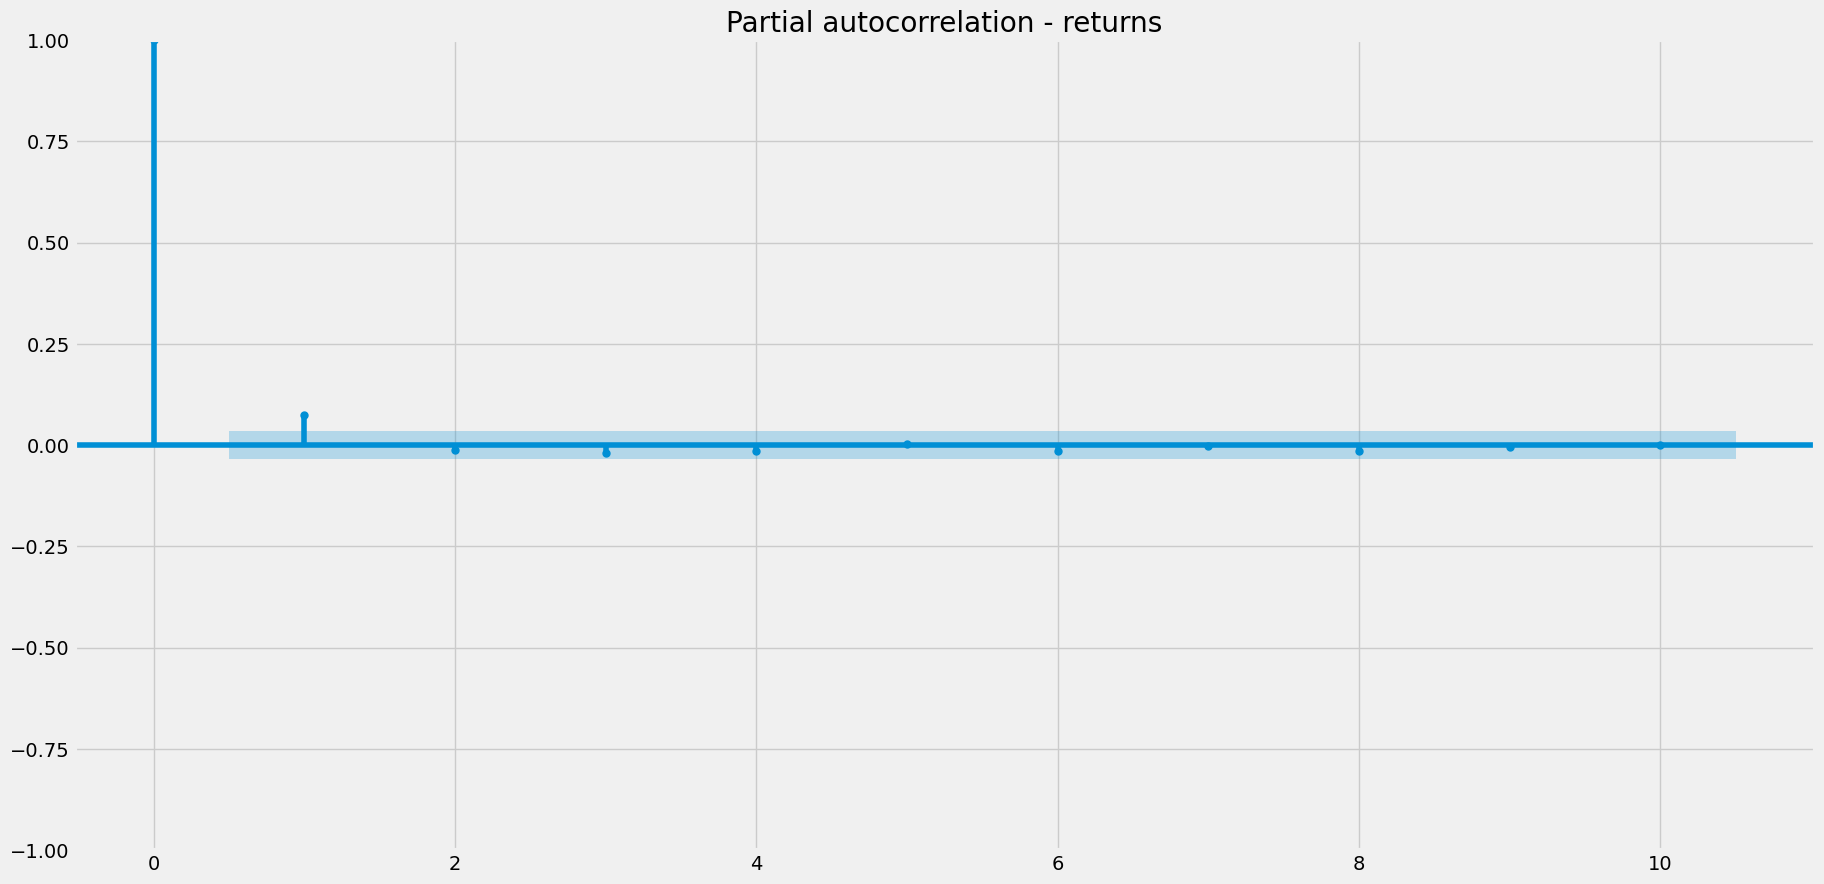

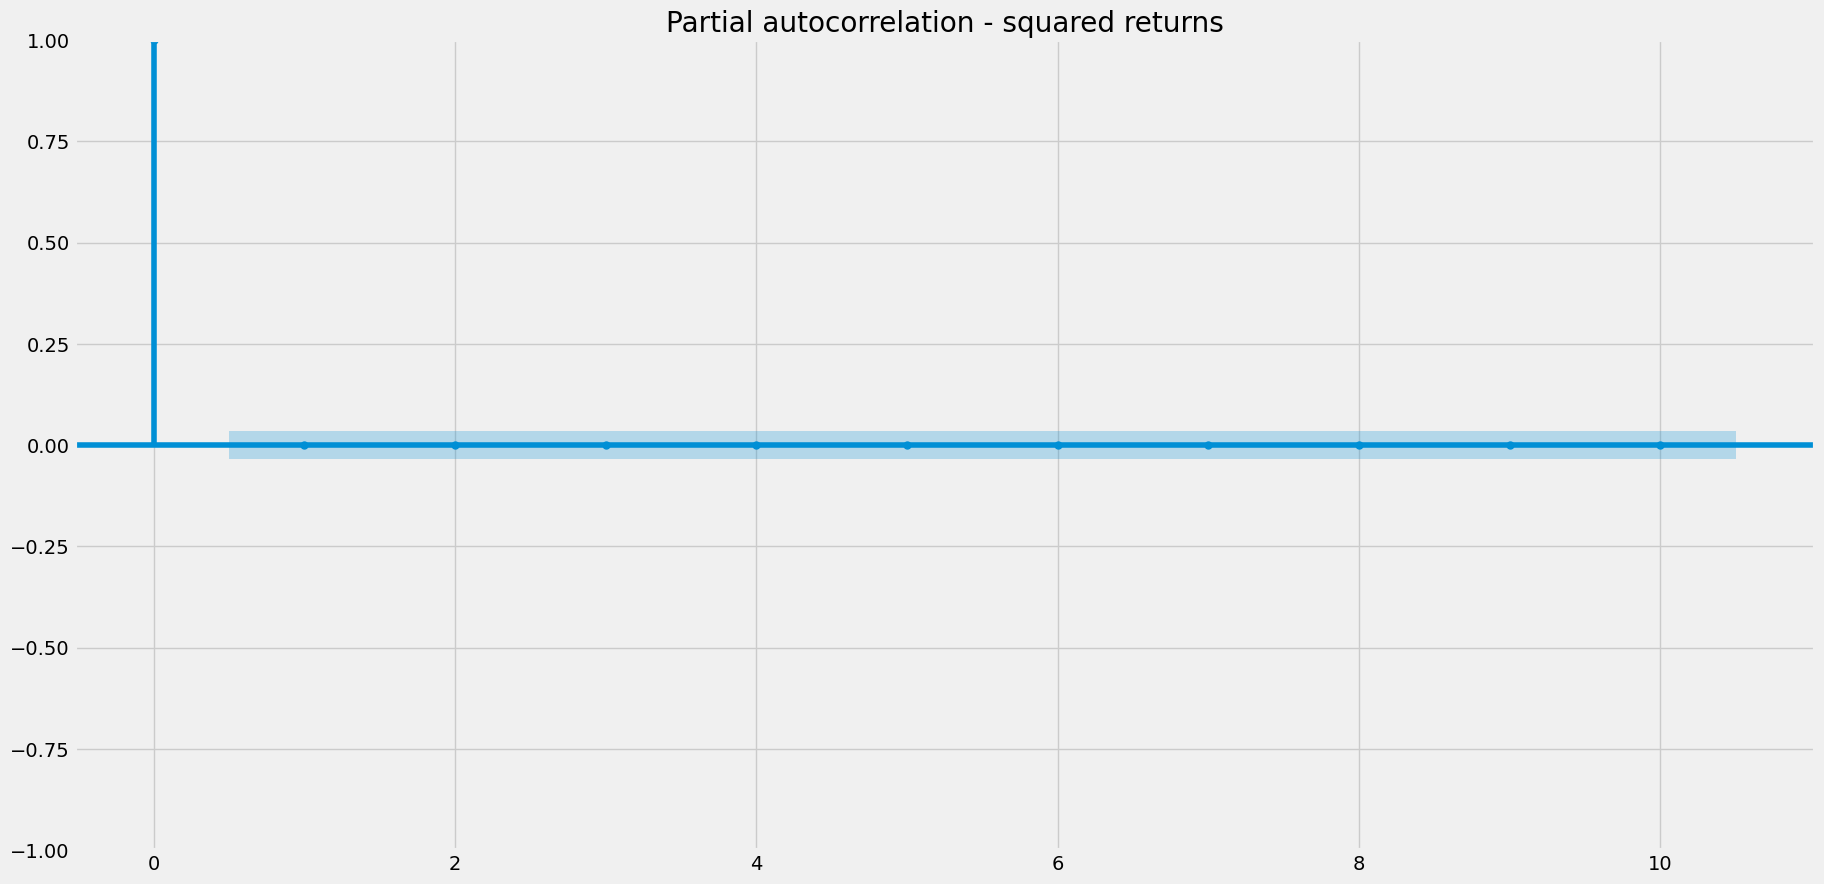

In [16]:
plot_pacf(dfl, lags = 10, title='Partial autocorrelation - returns'); print()
plot_pacf(dfl**2, lags = 10, title='Partial autocorrelation - squared returns'); print()

La **PACF** muestra la correlación entre las observaciones separadas por un cierto número de períodos de tiempo, después de ajustar para la presencia de otros términos de lags más corto. Al considerar solo la correlación específica para un lag dado, se eliminan la influencia de los lags anteriores.

## Modelo ARCH

Tiene el objetivo de representar los episodios de agrupamiento temporal de volatilidad que a menudo se observan en las series de tiempo.

Se utilizan para modelar la varianza condicional de una serie de tiempo.

In [17]:
from arch import arch_model

am = arch_model(100 * dfl, p = 1, q = 0)
res = am.fit(update_freq=5) # Ajusta el modelo a los datos y devuelve un objeto de resultados 
print(res.summary())

Iteration:      5,   Func. Count:     29,   Neg. LLF: 9083.399746528281
Iteration:     10,   Func. Count:     50,   Neg. LLF: 9050.552552852314
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9050.552545114904
            Iterations: 12
            Function evaluations: 57
            Gradient evaluations: 12
                      Constant Mean - ARCH Model Results                      
Dep. Variable:                   VWAP   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -9050.55
Distribution:                  Normal   AIC:                           18107.1
Method:            Maximum Likelihood   BIC:                           18125.4
                                        No. Observations:                 3321
Date:                Wed, Mar 20 2024   Df Residuals:                     3320
Time:          

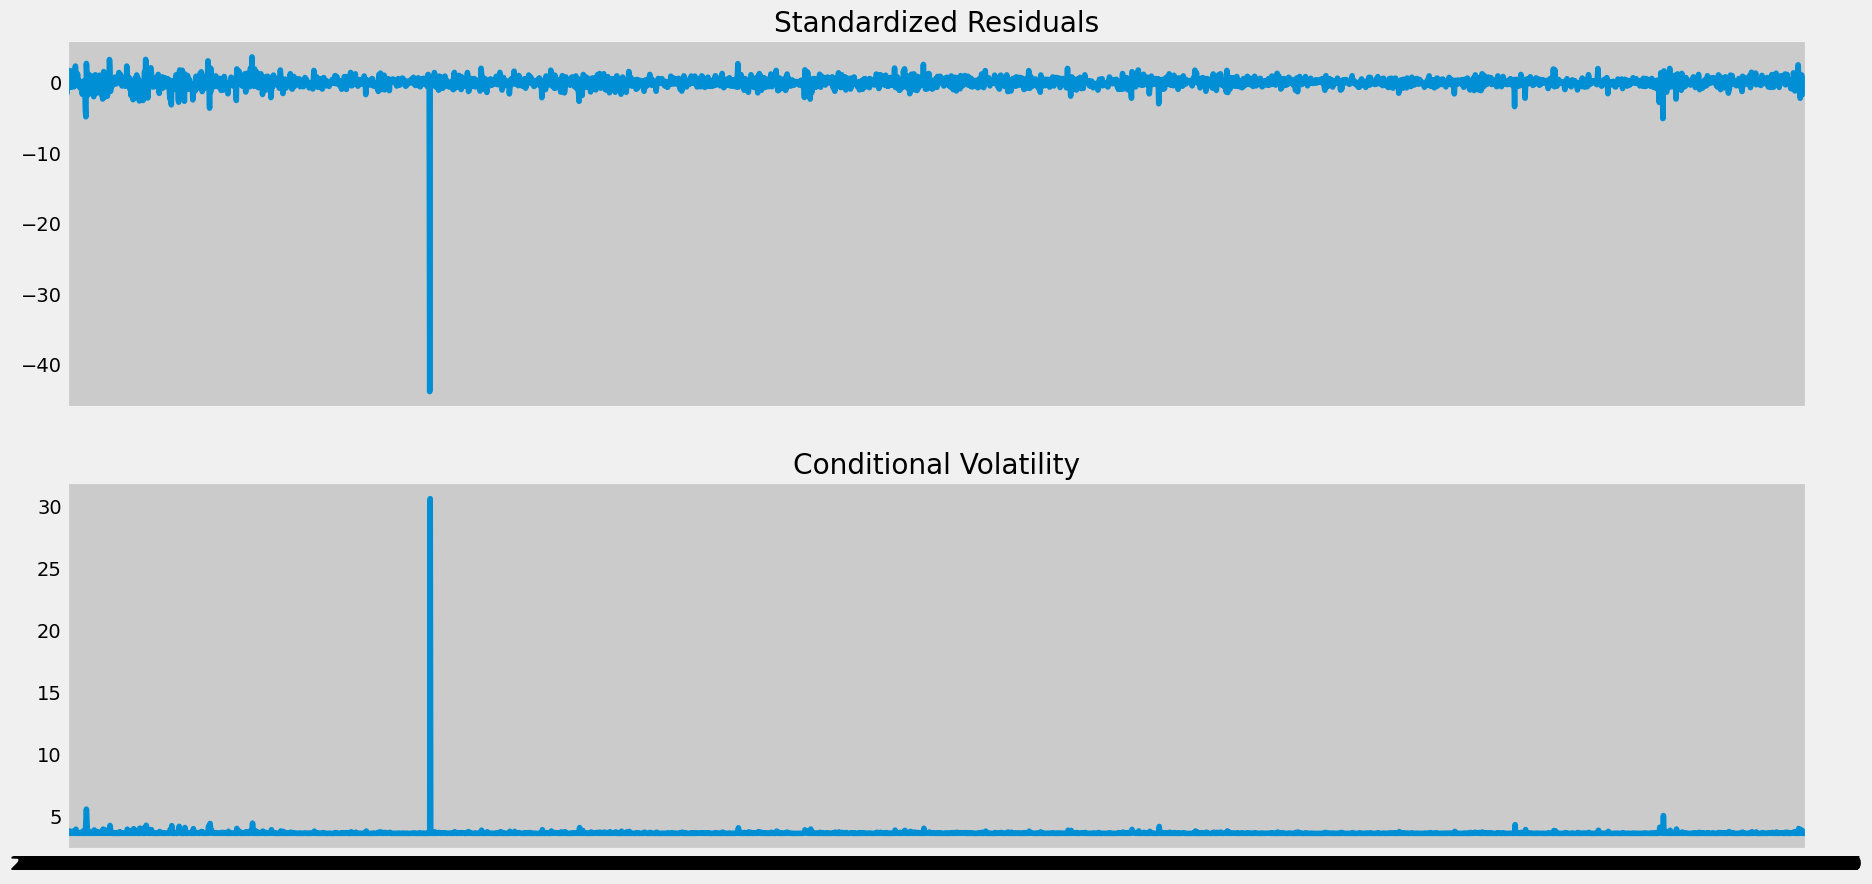

In [18]:
res.plot(); print()

Diagnósticos en el modelo:

1. **Ljung-Box**:
   - Es una prueba para la autocorrelación (utilizable junto con gráficos ACF / PACF).
   - H0: Los datos están distribuidos de manera independiente, sin autocorrelación.
   - H1: Existe correlación.

2. **Engle ARCH**:
   - Utiliza la prueba Ljung-Box y una prueba de multiplicador de Lagrange para determinar si el modelo ARCH ha capturado la heteroscedasticidad condicional.
   - H0: Los residuos son homocedásticos.
   - H1: Los residuos al cuadrado muestran heteroscedasticidad(la volatilidad cambia con el tiempo, periodos de mayor volatilidad y otros de poca volatilidad).

In [20]:
max_lags = 5
residuals = res.resid #guarda los residuos, la diferencia entre el valor real y el valor predicho
st_residuals = np.divide(res.resid, res.conditional_volatility) 
#divide los residuos por la volatilidad condicional
#la volatilidad condicional es la volatilidad que se espera en el futuro

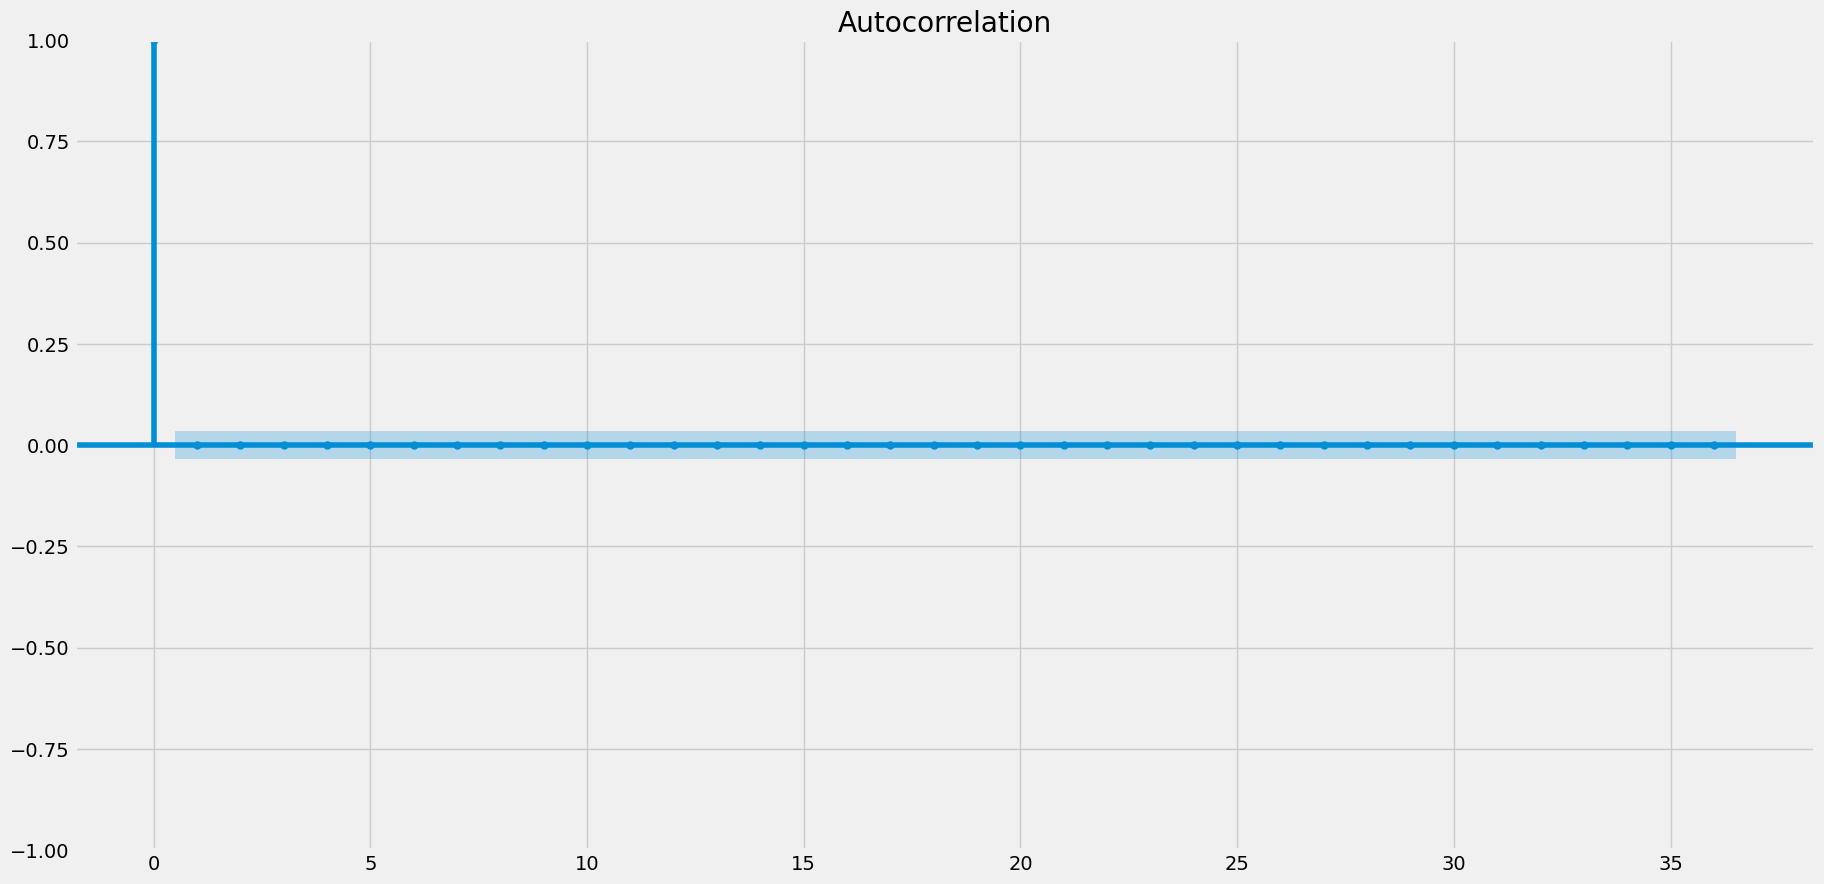

In [21]:
plot_acf(dfl ** 2); print()

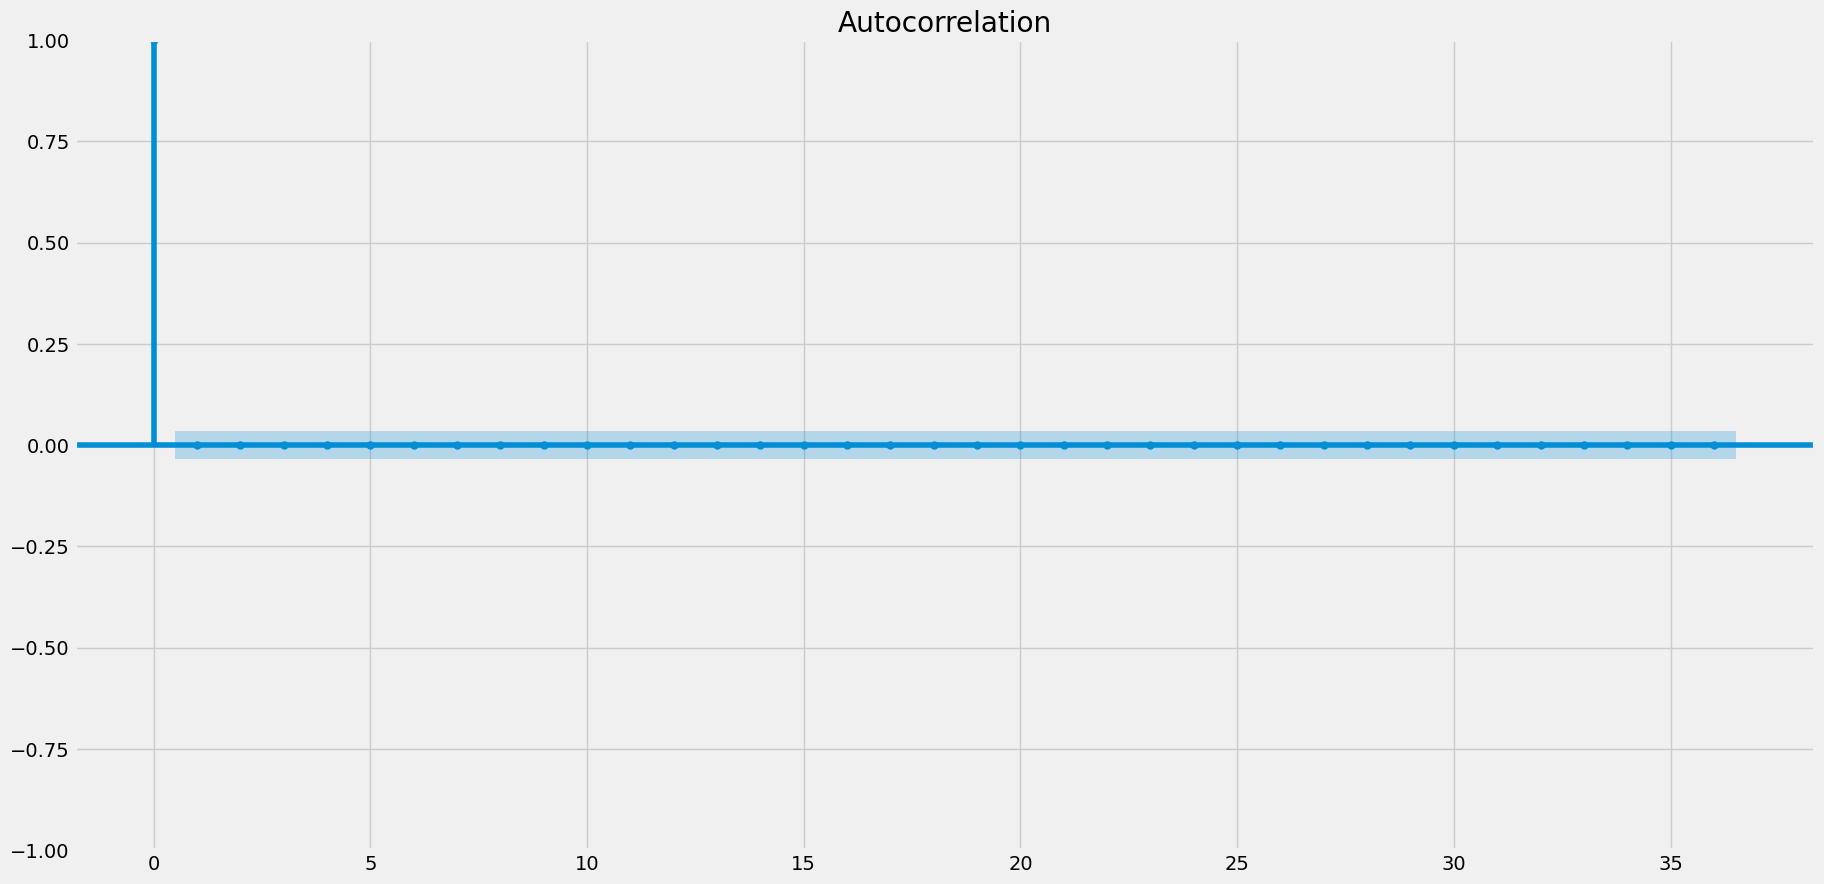

In [22]:
plot_acf(st_residuals ** 2); print()

In [25]:
# Ljung-Box

lb_test = acorr_ljungbox(dfl ** 2 , lags = max_lags)
print(lb_test)

#Si el valor p es pequeño, se rechaza la hipótesis nula y se concluye que hay autocorrelación.

    lb_stat  lb_pvalue
1  0.000154   0.990098
2  0.000373   0.999813
3  0.000449   0.999997
4  0.001136   1.000000
5  0.001561   1.000000


In [26]:
lb_test = acorr_ljungbox(st_residuals ** 2 , lags = max_lags)

print(lb_test)

    lb_stat  lb_pvalue
1  0.000667   0.979392
2  0.000992   0.999504
3  0.001057   0.999991
4  0.001761   1.000000
5  0.002163   1.000000


In [27]:
# Engle ARCH
etest = het_arch(dfl, maxlag=5)
print('pval Lagrange: ' + str(np.round(etest[1],4)))
print('pval F-test: ' + str(np.round(etest[1],4)))

#El p-value indica la significancia estadística del test...
#... Si es pequeño, sugiere que hay heteroscedasticidad condicional en los residuos

pval Lagrange: 1.0
pval F-test: 1.0


In [28]:
etest = het_arch(st_residuals, maxlag=5)
print('pval Lagrange: ' + str(np.round(etest[1],4)))
print('pval F-test: ' + str(np.round(etest[1],4)))

pval Lagrange: 1.0
pval F-test: 1.0


## Modelo GARCH

Permite modelar la varianza de una serie de tiempo en función de sus propios rezagos y los rezagos de los residuos al cuadrado. 

- p: número de términos lag de los errores.
- q: número de términos lag de las varianzas.


En teoría, puedes especificar diferentes órdenes de \(p\) y \(q\), pero a menos que tengas una buena razón para pensar lo contrario, generalmente es recomendable comenzar con (1,1).



In [30]:
gm = arch_model(100 * dfl, p = 1, q = 1)
res = gm.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     32,   Neg. LLF: 9221.021276701782
Iteration:     10,   Func. Count:     59,   Neg. LLF: 9045.047453893018
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9045.04499605526
            Iterations: 14
            Function evaluations: 78
            Gradient evaluations: 14
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   VWAP   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -9045.04
Distribution:                  Normal   AIC:                           18098.1
Method:            Maximum Likelihood   BIC:                           18122.5
                                        No. Observations:                 3321
Date:                Wed, Mar 20 2024   Df Residuals:                     3320
Time:           

In [32]:
# Ljung-Box
residuals = res.resid #guarda los residuos, la diferencia entre el valor real y el valor predicho
st_residuals = np.divide(res.resid, res.conditional_volatility)
lb_test = acorr_ljungbox(dfl ** 2 , lags = max_lags)
print(lb_test)

    lb_stat  lb_pvalue
1  0.000154   0.990098
2  0.000373   0.999813
3  0.000449   0.999997
4  0.001136   1.000000
5  0.001561   1.000000


In [33]:
lb_test = acorr_ljungbox(st_residuals ** 2 , lags = max_lags)
print(lb_test)

    lb_stat  lb_pvalue
1  0.001080   0.973789
2  0.002467   0.998767
3  0.002497   0.999967
4  0.003215   0.999999
5  0.004078   1.000000


In [34]:
# Engle ARCH
etest = het_arch(dfl, maxlag=5)
print('pval Lagrange: ' + str(np.round(etest[1],4)))
print('pval F-test: ' + str(np.round(etest[1],4)))

pval Lagrange: 1.0
pval F-test: 1.0


In [35]:
etest = het_arch(st_residuals, maxlag=5)
print('pval Lagrange: ' + str(np.round(etest[1],4)))
print('pval F-test: ' + str(np.round(etest[1],4)))

pval Lagrange: 1.0
pval F-test: 1.0


## ARMA-GARCH

Hasta ahora, se ha asumido una media constante, lo cual a menudo no es cierto. Para abordar esto, secombinan los modelos **ARIMA** y **GARCH**:

1. **ARIMA (Media Móvil Integrada de Autoregresión)**: Estima la media condicional de la serie de tiempo.
2. **GARCH (Autoregresión Condicionada Heteroscedástica)**: Estima la varianza condicional en los residuos del modelo ARIMA.

La combinación de ambos modelos permite capturar tanto la tendencia de la serie de tiempo como la variabilidad en la varianza. A diferencia de la estimación secuencial, la estimación conjunta optimiza el rendimiento del forecast.


In [36]:
from arch.univariate import ARX

ar = ARX(100 * dfl, lags=[1, 3])
print(ar.fit().summary())

                     AR - Constant Variance Model Results                     
Dep. Variable:                   VWAP   R-squared:                       0.006
Mean Model:                        AR   Adj. R-squared:                  0.005
Vol Model:          Constant Variance   Log-Likelihood:               -9036.97
Distribution:                  Normal   AIC:                           18081.9
Method:            Maximum Likelihood   BIC:                           18106.4
                                        No. Observations:                 3318
Date:                Wed, Mar 20 2024   Df Residuals:                     3315
Time:                        22:04:43   Df Model:                            3
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
Const      -6.5182e-03  6.407e-02     -0.102      0.

In [37]:
from arch.univariate import ARCH, GARCH

ar.volatility = GARCH(p=1, q = 1)
res = ar.fit(update_freq=0, disp="off")
print(res.summary())

                           AR - GARCH Model Results                           
Dep. Variable:                   VWAP   R-squared:                      -0.094
Mean Model:                        AR   Adj. R-squared:                 -0.095
Vol Model:                      GARCH   Log-Likelihood:               -8998.45
Distribution:                  Normal   AIC:                           18008.9
Method:            Maximum Likelihood   BIC:                           18045.5
                                        No. Observations:                 3318
Date:                Wed, Mar 20 2024   Df Residuals:                     3315
Time:                        22:05:47   Df Model:                            3
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
Const         -0.1192  8.574e-02     -1.390      0.164 [ -0.287,

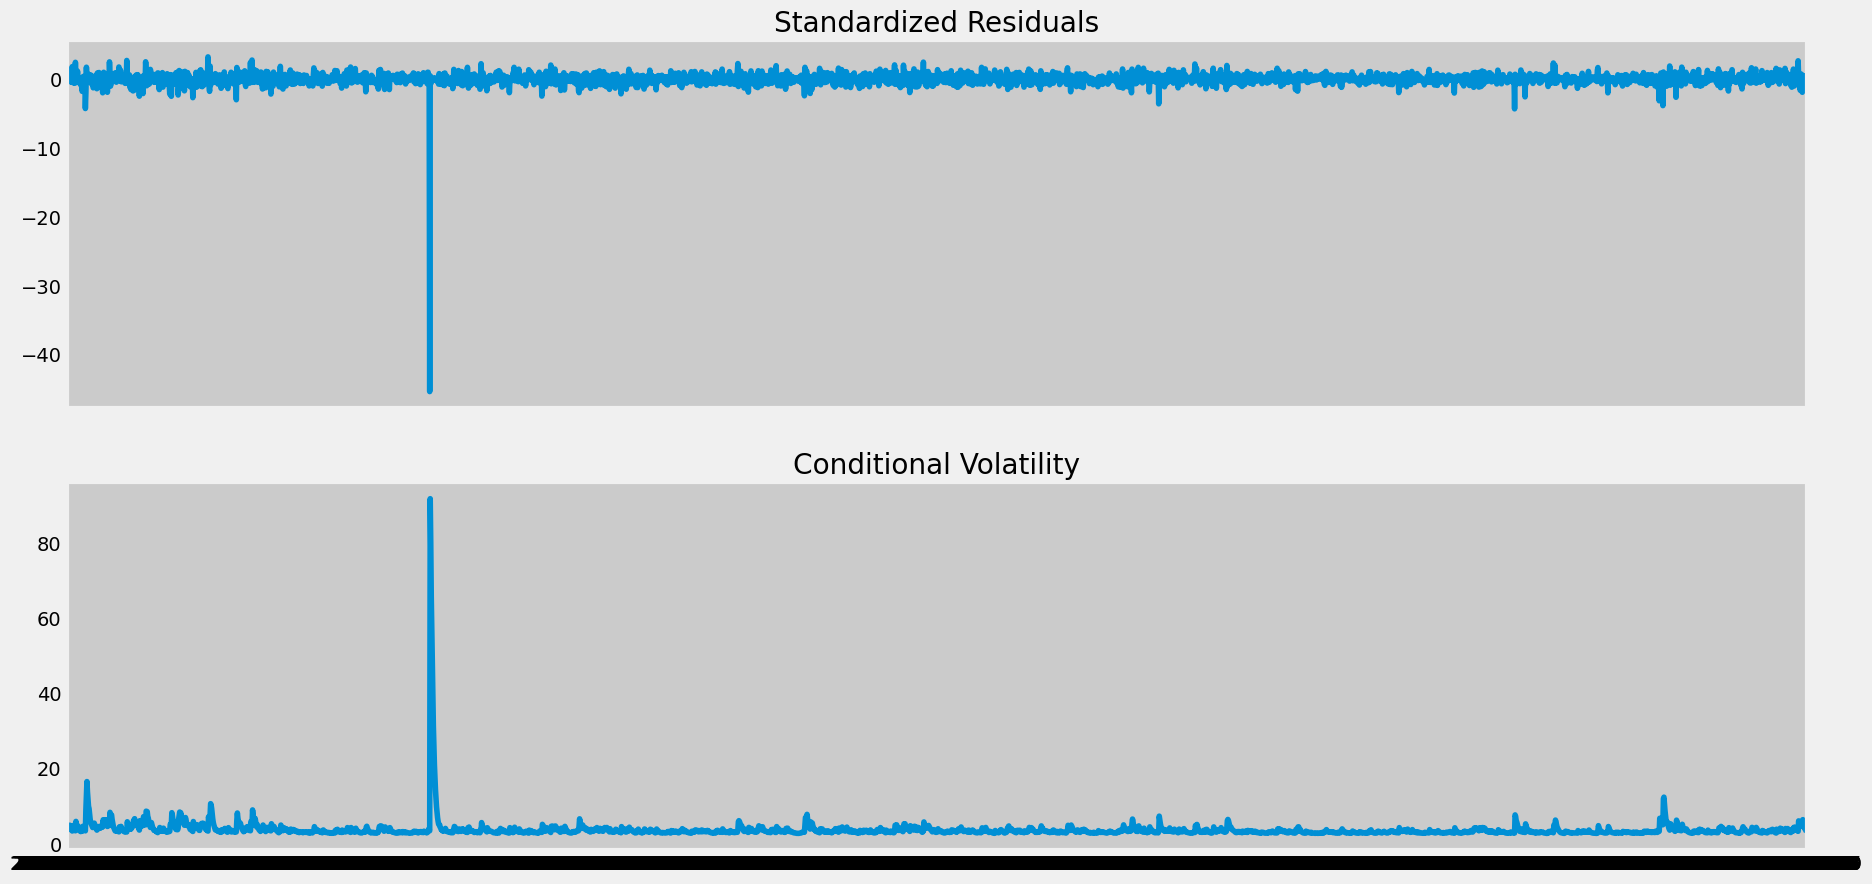

In [38]:
fig = res.plot()

## Forecasting



- **Pronósticos de múltiples pasos**:
    - **Recursión**: Utiliza un enfoque recursivo para predecir varios pasos en el futuro.
    - **Forma analítica**: Expresión matemática que describe directamente el pronóstico sin necesidad de iteraciones.
    - **Lineal en el residuo al cuadrado**: Implica que la relación entre las variables es lineal en función del residuo al cuadrado.

- **Simulación**:
    - Se basa en una **distribución paramétrica** para generar pronósticos futuros.
    - Utiliza una función de distribución específica para simular posibles escenarios.

- **Bootstrap**:
    - Similar a la simulación, pero utiliza los **residuos empíricos** (observados) en lugar de una distribución paramétrica.
    - Es una técnica de remuestreo que permite estimar la incertidumbre en los pronósticos mediante la repetición de muestras aleatorias de los datos originales.



In [39]:
dfl = np.log1p(df.VWAP).diff().dropna()
print(dfl.index.min(), dfl.index.max())

2007-11-28 2021-04-30


In [40]:
#Partir la data en 2

xtr, xval = dfl.loc[:'2021-01-01'], dfl.loc['2021-01-01':]

In [41]:
# fit the model 

ar = ARX(100 * xtr, lags=[1])
ar.volatility = GARCH(p=1, q = 1)
res = ar.fit(update_freq=0, disp="off")
print(res.summary())

                           AR - GARCH Model Results                           
Dep. Variable:                   VWAP   R-squared:                      -0.005
Mean Model:                        AR   Adj. R-squared:                 -0.005
Vol Model:                      GARCH   Log-Likelihood:               -8829.28
Distribution:                  Normal   AIC:                           17668.6
Method:            Maximum Likelihood   BIC:                           17699.0
                                        No. Observations:                 3241
Date:                Wed, Mar 20 2024   Df Residuals:                     3239
Time:                        22:08:28   Df Model:                            2
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
Const         -0.0702      0.137     -0.514      0.607   [ -0.33

In [44]:
# build the forecast
xfor = res.forecast(horizon= xval.shape[0]) 
#forecast es una función que predice el valor futuro de la serie de tiempo
#horizon es el número de pasos futuros a predecir
mean_forecast = xfor.mean.tail(1).values.reshape(len(xval),1)

forecast = pd.DataFrame()
forecast['Date'] = xval.index
forecast['VWAP'] = xval.values
forecast['fc_mean'] = xfor.mean.tail(1).values.reshape(len(xval),1)
forecast['fc_std'] = np.sqrt(xfor.variance.tail(1).values.reshape(len(xval),1))

In [43]:
forecast

,Date,VWAP,fc_mean,fc_std
0,2021-01-01,0.019029,0.252591,3.543404
1,2021-01-04,0.011573,-0.027390,3.745383
2,2021-01-05,-0.004409,-0.074890,3.860827
3,2021-01-06,-0.000100,-0.082948,3.944620
4,2021-01-07,0.026033,-0.084315,4.006483
...,...,...,...,...
75,2021-04-26,-0.000463,-0.084595,4.188827
76,2021-04-27,0.019449,-0.084595,4.188827
77,2021-04-28,0.004465,-0.084595,4.188827
78,2021-04-29,0.002709,-0.084595,4.188827
